# RLDatix Data Science Assignment

#### J Montgomery Maxwell

### Import Packages & Read Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import mutual_info_classif

In [3]:
import spacy
from spacy.pipeline import EntityRuler

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import re

/opt/anaconda3/envs/rltest/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Task 1 - Predictive Modelling (Binary Classification)

In [4]:
random_seed = 42

df = pd.read_excel("Assignment_Data.xlsx")

print(f"Data Fields = {df.columns}")
print(f"Missing Data = {df.isna().sum().sum()}")
df.head()

Data Fields = Index(['patient_id', 'age', 'gender', 'diagnosis_code',
       'num_previous_admissions', 'medication_type', 'length_of_stay',
       'readmitted_30_days', 'discharge_note'],
      dtype='object')
Missing Data = 0


,patient_id,age,gender,diagnosis_code,num_previous_admissions,medication_type,length_of_stay,readmitted_30_days,discharge_note
0,1,71,Male,D002,3,Type C,2,0,Good recovery trajectory. Follow-up scan sched...
1,2,34,Female,D002,1,Type B,3,1,Stable post-surgery. Advised to avoid physical...
2,3,80,Male,D002,2,Type C,5,1,Symptoms controlled. Monitoring for relapse ad...
3,4,40,Female,D002,2,Type C,11,0,Stable post-surgery. Advised to avoid physical...
4,5,43,Female,D001,1,Type C,8,1,Stable post-surgery. Advised to avoid physical...


Looking through the data initially, there is no missing data. 

There are three numerical fields (age, number of previous admissions, and length of stay). 
There are three categorical/binary fields (gender, diagnosis code, and medication type). 
There is one binary predictor field, readmitted within 30 days. 

Our goals are the following:
1. Split the data into a training and hold out test set.
2. Run initial exploratory data analysis to see the distribution of the variables and to see if any of the variables stand out as for there predictive ability.
3. Prepare the data for modeling, encoding the categorical variables and removing any variables that are not needed.
4. Engineer any additional features.
5. Run modeling using cross validation to choose the optimal probability threshold for predictions.
6. Train a final model and test against the hold out test set.
7. See which features are the most informative.  

### Split Data

We split data in a training set for cross validation and a final, hold-out test set for final verification. Because the classes are imbalanced, we stratify the split to insure the test set has a proportional number of positive cases.

In [5]:
X = df.drop('readmitted_30_days', axis=1)
y = df[['patient_id', 'readmitted_30_days']]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y.readmitted_30_days, test_size=0.2, random_state=random_seed)
del X, y

### Data Preperation and Encoding

In [6]:
def data_preperation_pipeline(df, k_encoding_features, k_minus_1_encoding_features):

    encoded_df = 1*pd.get_dummies(df, columns=k_minus_1_encoding_features, drop_first=True)
    encoded_df = 1*pd.get_dummies(encoded_df, columns=k_encoding_features, drop_first=False)
    
    return encoded_df

X_train_encoded = data_preperation_pipeline(X_train, ['diagnosis_code', 'medication_type', 'gender'], [])
X_train_encoded.head()

,patient_id,age,num_previous_admissions,length_of_stay,discharge_note,diagnosis_code_D001,diagnosis_code_D002,diagnosis_code_D003,diagnosis_code_D004,medication_type_Type A,medication_type_Type B,medication_type_Type C,gender_Female,gender_Male
191,192,30,1,3,Patient showed improvement. Prescribed antibio...,0,0,0,1,0,1,0,0,1
188,189,59,1,13,Patient discharged in stable condition. Recomm...,0,0,1,0,0,1,0,1,0
162,163,63,0,10,Symptoms controlled. Monitoring for relapse ad...,0,0,0,1,0,1,0,1,0
139,140,56,0,3,Patient discharged in stable condition. Recomm...,0,0,1,0,0,0,1,1,0
121,122,64,2,6,Mild reaction to medication. Switched to alter...,0,1,0,0,1,0,0,0,1


### Exploratory Analysis

Now we'll get some preliminary understanding of the makeup of the features and their influence.

The features appear to each be relatively evenly distributed, with the exception of age and num_previous_admissions. The age feature might be skewed in frequency towards the lower end if all data collected for those under the age of 20 were encoded to 20 for the purpose of deidentification, which is not uncommon for data from children and the elderly.

None of the features appear to highly correlate with readmitted_30_days and the mutual information estimates are low. Because none of the features particularly stand out, we will keep all of the features.

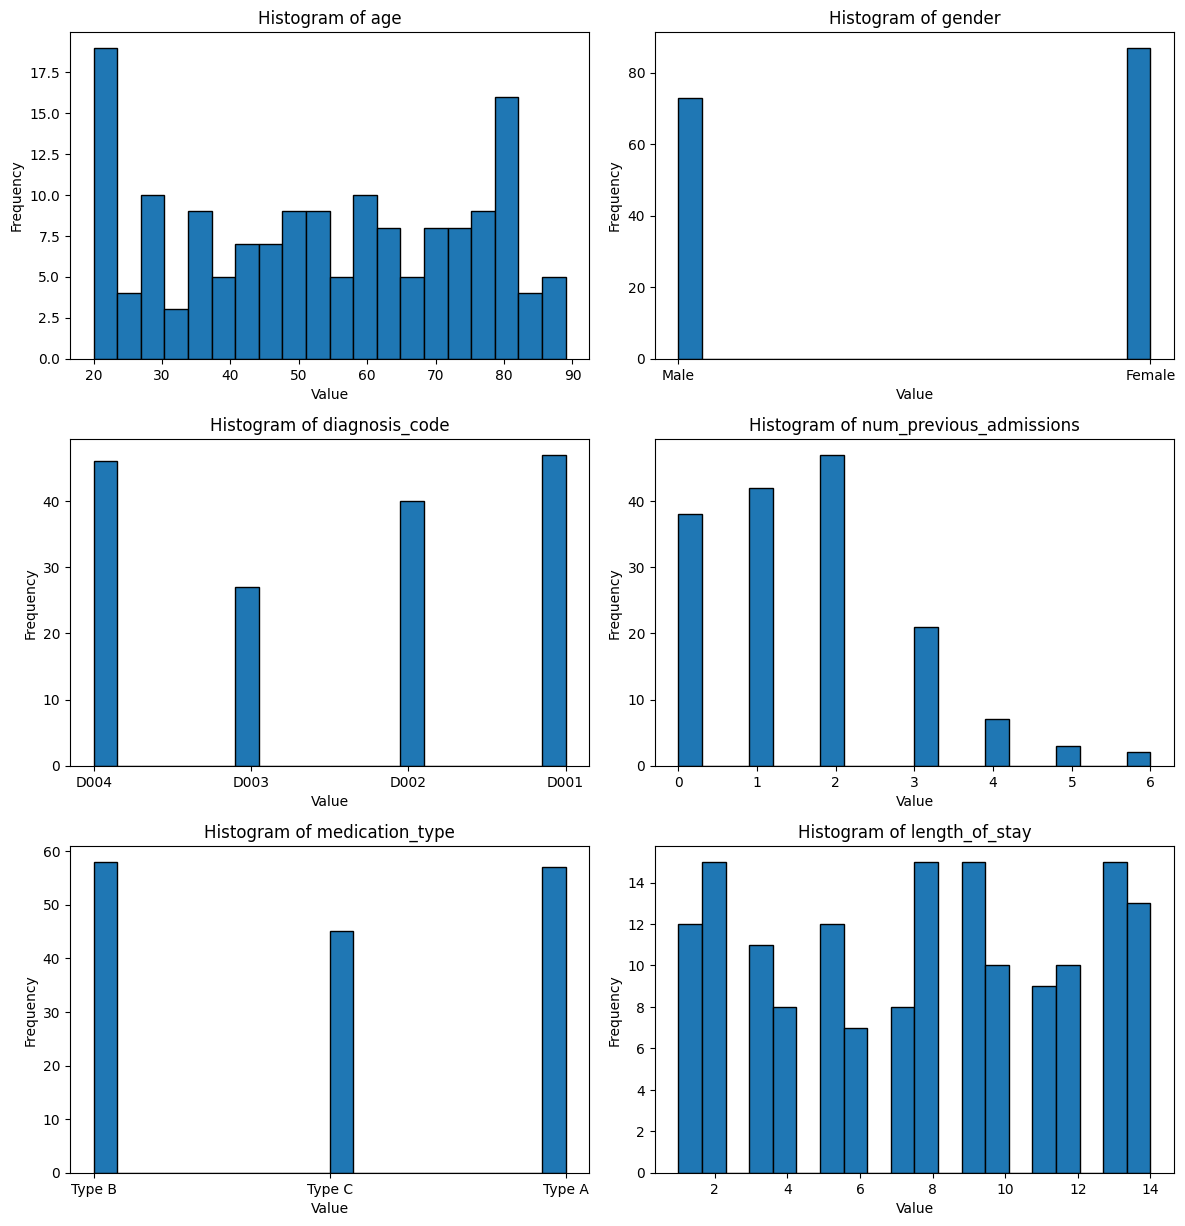

In [7]:
fig, axes = plt.subplots(4, 2, figsize=(12, 4 * 4))

# Flatten the axes array to easily iterate through a 1D list
axes_flat = axes.flatten()

# Loop through the features and plot histograms

df = pd.read_excel("Assignment_Data.xlsx")
features = ['age', 'gender', 'diagnosis_code', 'num_previous_admissions', 'medication_type', 'length_of_stay'] #, 'readmitted_30_days']


for i, feature in enumerate(features):
    ax = axes_flat[i] # Select the current axis
    ax.hist(X_train[feature], bins=20, edgecolor='black') # Plot the histogram
    ax.set_title(f'Histogram of {feature}') # Set a title for the subplot
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

for j in range(i + 1, len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.tight_layout()
plt.show()

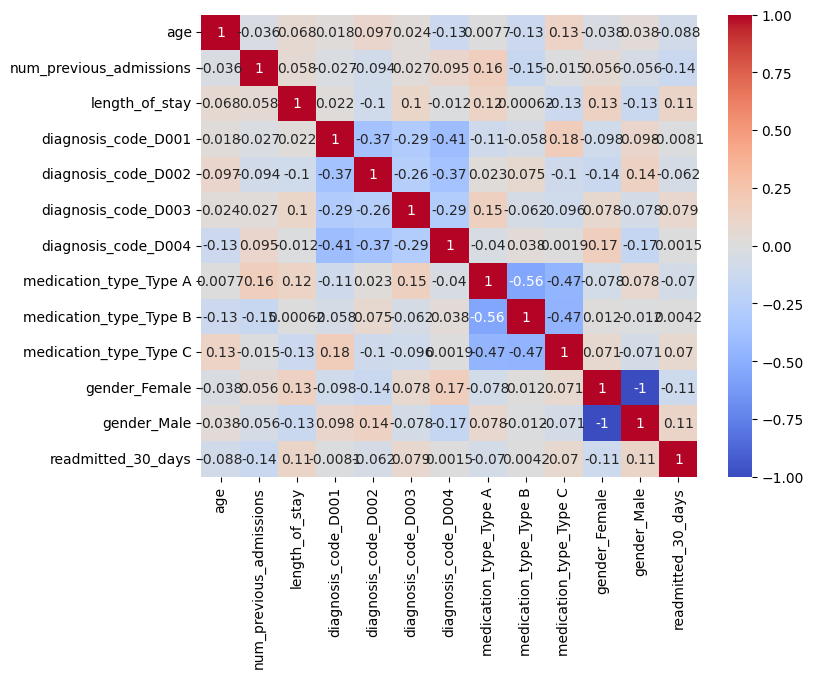

In [8]:
plt.figure(figsize = (8, 6))
sns.heatmap(X_train_encoded.merge(y_train, how='left', on='patient_id').drop(['patient_id', 'discharge_note'], axis=1).corr(), annot=True, cmap='coolwarm')
plt.show()

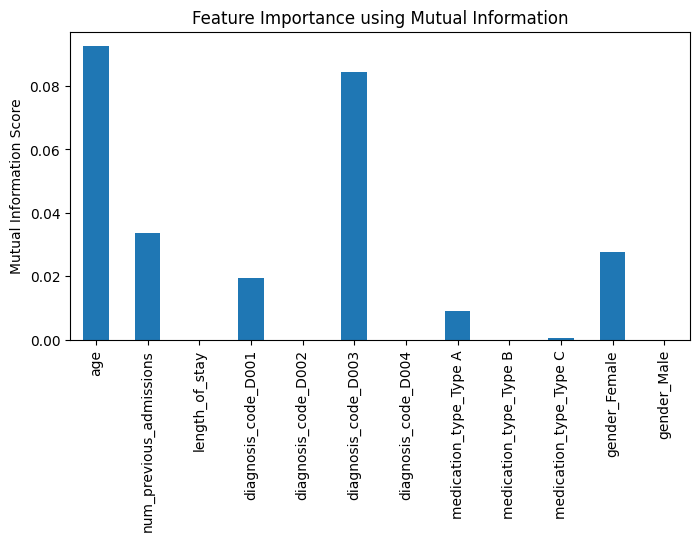

In [9]:
MI_scores = mutual_info_classif(X_train_encoded.drop(['patient_id', 'discharge_note'], axis=1), 
                                y_train.readmitted_30_days, 
                                n_neighbors = 3, 
                                random_state=42)

MI_df = pd.Series(MI_scores, index=X_train_encoded.drop(['patient_id', 'discharge_note'], axis=1).columns)
MI_df.plot.bar(figsize=(8, 4))
plt.title("Feature Importance using Mutual Information")
plt.ylabel("Mutual Information Score")
plt.show()

### Feature Engineering

Assuming length_of_stay was for the most recent visit. We will create a new feature that measures the total amount of time in the hospital by multiplying num_previous_admissions and length_of_stay. 

Given more time I would investigate engineering features around the intersection of diagnosis codes and medication types. But for now, I will hope the random forest model catches these relations if they exist. 

I also looked at polynomial, logarithmic, and exponential factors of the numerical features and none of them stood out to be particularly significant. Because there is no heuristic justification for using these engineered features I chose to leave them out.

In [10]:

X_train_encoded['num_previous_admissions * length_of_stay'] = X_train_encoded['length_of_stay']*X_train_encoded['num_previous_admissions']

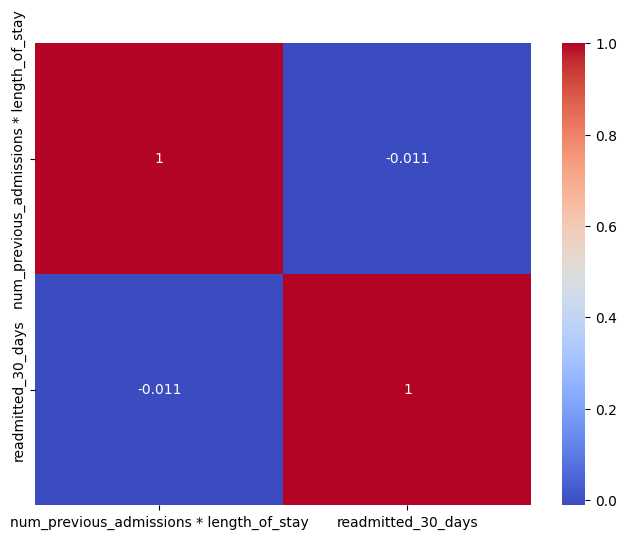

In [11]:
new_feature = ['num_previous_admissions * length_of_stay']

plt.figure(figsize = (8, 6))
sns.heatmap(X_train_encoded.merge(y_train, how='left', on='patient_id')[new_feature + ['readmitted_30_days']].corr(), annot=True, cmap='coolwarm')
plt.show()

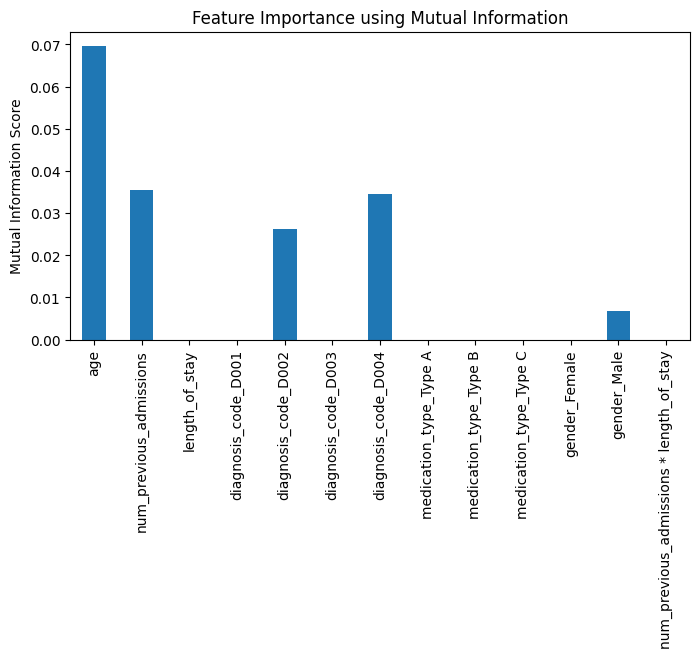

In [12]:
MI_scores = mutual_info_classif(X_train_encoded.drop(['patient_id', 'discharge_note'], axis=1), 
                                y_train.readmitted_30_days, 
                                n_neighbors = 3, 
                                random_state=42)

MI_df = pd.Series(MI_scores, index=X_train_encoded.drop(['patient_id', 'discharge_note'], axis=1).columns)
MI_df.plot.bar(figsize=(8, 4))
plt.title("Feature Importance using Mutual Information")
plt.ylabel("Mutual Information Score")
plt.show()

### Cross Validation

Now I run K=5 fold cross validation. I use random undersampling during training for the majority class, but I did also try SMOTE to resolve the class imbalance. Overall I believe RUS to be better than SMOTE in this instance because it gave a slightly greater average Recall score and ROC AUC score, which I believe are the preferred performance metric for this task and because I'm concerned there is not enough data to appropriately support SMOTE.

During Cross Validation we achieve an average recall = 0.77, ROC AUC = 0.53, and F1 = 0.52. We also use Cross validation to choose an average probability threshold of 0.436 for our final model's predictions.

From the confusion matrix and precision score we can see that there are quite a few false positives. I would want to reduce the FPR for a model like this before introducing it to production. 

In [13]:
def cross_validation_pipeline(X, y, K):
    scores = {'precision': [], 'recall': [], 'accuracy': [], 'f1_score': [], 'roc_auc': []}
    confusion_matrix_cv = {'TP': 0, 'FP': 0, 'TN': 0, 'FN': 0} 
    optimal_thresholds = []

    model = RandomForestClassifier(n_estimators=100, random_state=random_seed)
    smote = SMOTE(random_state=random_seed)
    rus = RandomUnderSampler(random_state=random_seed)

    skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=random_seed)  
    for i, (train_index, test_index) in enumerate(skf.split(X, y.readmitted_30_days)):

        # 'train_index' and 'test_index' are the arrays of indices for each fold
        X_cv_train, X_cv_test = X.iloc[train_index].reset_index(drop=True), X.iloc[test_index].reset_index(drop=True)
        y_cv_train, y_cv_test = y.iloc[train_index].readmitted_30_days, y.iloc[test_index].readmitted_30_days

        X_train_resampled, y_train_resampled = rus.fit_resample(X_cv_train, y_cv_train)
        #X_train_resampled, y_train_resampled = smote.fit_resample(X_cv_train, y_cv_train)

        model.fit(X_train_resampled, y_train_resampled)
    
        y_cv_probs = model.predict_proba(X_cv_test)[:, 1]

        fpr, tpr, thresholds = roc_curve(y_cv_test, y_cv_probs)
        optimal_idx = (tpr - fpr).argmax()
        optimal_threshold = thresholds[optimal_idx]
        optimal_thresholds.append(optimal_threshold)

        y_pred_optimal = (y_cv_probs >= optimal_threshold).astype(int)
        

        tn, fp, fn, tp = confusion_matrix(y_cv_test, y_pred_optimal).ravel()
        confusion_matrix_cv['TP'] += tp
        confusion_matrix_cv['FP'] += fp
        confusion_matrix_cv['TN'] += tn
        confusion_matrix_cv['FN'] += fn

        scores['roc_auc'].append(roc_auc_score(y_cv_test, y_cv_probs))
        scores['precision'].append(precision_score(y_cv_test, y_pred_optimal))
        scores['recall'].append(recall_score(y_cv_test, y_pred_optimal))
        scores['accuracy'].append(accuracy_score(y_cv_test, y_pred_optimal))
        scores['f1_score'].append(f1_score(y_cv_test, y_pred_optimal))

    return scores, optimal_thresholds, confusion_matrix_cv


In [14]:
scores, optimal_thresholds, confusion_matrix_cv = cross_validation_pipeline(X_train_encoded.drop(['patient_id', 'discharge_note'], axis=1), 
                                                                            y_train, 
                                                                            K=5)

In [15]:
avg_scores = {}
for key in scores:
    avg_scores[key] = np.mean(scores[key])
avg_scores

{'precision': 0.42513227513227514,
 'recall': 0.7727272727272727,
 'accuracy': 0.5625,
 'f1_score': 0.5186996904024768,
 'roc_auc': 0.5282467532467533}

{'TP': 40, 'FP': 58, 'TN': 50, 'FN': 12}


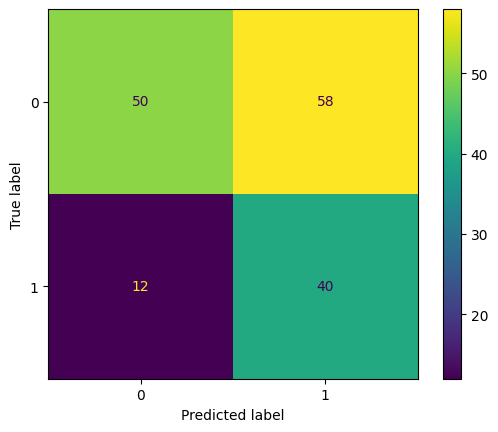

In [16]:
print(confusion_matrix_cv)
disp = ConfusionMatrixDisplay(np.array([[confusion_matrix_cv['TN'], confusion_matrix_cv['FP']], [confusion_matrix_cv['FN'], confusion_matrix_cv['TP']]]))
disp.plot()
plt.show()

In [17]:
print(f"Optimal probability thresholds chosen in cross-validation: {optimal_thresholds}")
print(f"Average optimal probability threshold: {np.round(np.mean(optimal_thresholds), 3)}")

Optimal probability thresholds chosen in cross-validation: [0.3, 0.57, 0.35, 0.57, 0.39]
Average optimal probability threshold: 0.436


### Final Training And Testing

Now we will use what we learned from Cross Validation to evaluate the final model. 

In [18]:
X_test = data_preperation_pipeline(X_test, ['diagnosis_code', 'medication_type', 'gender'], [])
X_test['num_previous_admissions * length_of_stay'] = X_test['length_of_stay']*X_test['num_previous_admissions']

In [19]:
model = RandomForestClassifier(n_estimators=100, random_state=random_seed)
smote = SMOTE(random_state=random_seed)
rus = RandomUnderSampler(random_state=random_seed)

X_train_resampled, y_train_resampled = rus.fit_resample(X_train_encoded.drop(['patient_id', 'discharge_note'], axis=1), 
                                                        y_train.readmitted_30_days)

#X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded.drop(['patient_id', 'discharge_note'], axis=1), 
#                                                          y_train.readmitted_30_days)

model.fit(X_train_resampled, y_train_resampled)

y_probs = model.predict_proba(X_test.drop(['patient_id', 'discharge_note'], axis=1))[:, 1]

### Evaluation

The model does not perform nearly as well on our final test set, which suggests overfitting to some extent. 

Age and the engineered feature num_previous_admissions * length_of_stay appear to be the most influential features. 

Given more time I would look into engineering more features and removing some features from the model (determined through cross validation).

In [20]:
y_pred = (y_probs >= np.round(np.mean(optimal_thresholds), 3) ).astype(int)

print("ROC AUC =", roc_auc_score(np.array(y_test.readmitted_30_days), y_probs))
print("precision =", precision_score(np.array(y_test.readmitted_30_days), y_pred))
print("recall =", recall_score(np.array(y_test.readmitted_30_days), y_pred))
print("accuracy =", accuracy_score(np.array(y_test.readmitted_30_days), y_pred))
print("f1 =", f1_score(np.array(y_test.readmitted_30_days), y_pred))

ROC AUC = 0.4757834757834758
precision = 0.30434782608695654
recall = 0.5384615384615384
accuracy = 0.45
f1 = 0.3888888888888889


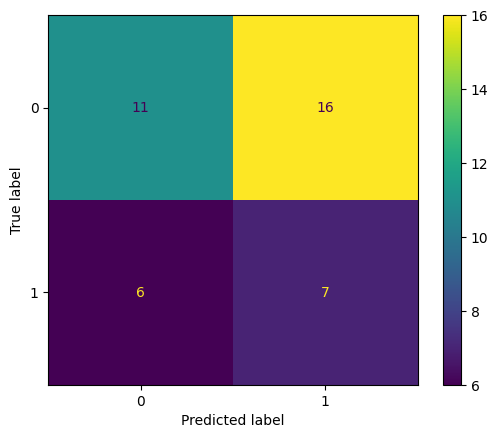

In [21]:
cm = confusion_matrix(np.array(y_test.readmitted_30_days), y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [22]:
importances = model.feature_importances_
feature_series = pd.Series(importances, index=X_train_encoded.drop(['patient_id', 'discharge_note'], axis=1).columns)

top_features = feature_series.sort_values(ascending=False)

print("Top Features:")
print(top_features.head(10)) # Display top 5 features

Top Features:
age                                         0.258971
num_previous_admissions * length_of_stay    0.181839
length_of_stay                              0.164615
num_previous_admissions                     0.126969
medication_type_Type A                      0.033674
medication_type_Type C                      0.033489
medication_type_Type B                      0.031480
gender_Male                                 0.030446
diagnosis_code_D003                         0.030218
gender_Female                               0.029476
dtype: float64


## Task 2 -  Named Entity Recognition from Discharge Notes

For this second task I tried using two different methods. The first uses an LLM to try to extract the pattern and the second uses the SpaCy package for entity extraction. Neither performed particularly well, the two methods were respectively limited by a small model size and a small number of encoded patterns.

### LLM Pattern Recognition

With the LLM approach we begin by reading in the data and loading a small open-source tokenizer and model. 

In [23]:
df = pd.read_excel("Assignment_Data.xlsx")
df.head()

,patient_id,age,gender,diagnosis_code,num_previous_admissions,medication_type,length_of_stay,readmitted_30_days,discharge_note
0,1,71,Male,D002,3,Type C,2,0,Good recovery trajectory. Follow-up scan sched...
1,2,34,Female,D002,1,Type B,3,1,Stable post-surgery. Advised to avoid physical...
2,3,80,Male,D002,2,Type C,5,1,Symptoms controlled. Monitoring for relapse ad...
3,4,40,Female,D002,2,Type C,11,0,Stable post-surgery. Advised to avoid physical...
4,5,43,Female,D001,1,Type C,8,1,Stable post-surgery. Advised to avoid physical...


In [24]:
model_id = "google/flan-t5-small"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

Next, we define a simple prompt format and a function for model inference.

In [25]:
def build_prompt(note):
    prompt =  f""" 
    Extract entities from the clinical note and give each entity one of the following labels: 
    DIAGNOSIS, SYMPTOM, MEDICATION, TREATMENT, FOLLOW_UP. 
    
    Use the following example as a guide and then apply it to the real case.

    Example:
    Clinical note:
    Patient has diabetes and is taking metformin.

    Extracted entities:
    DIAGNOSIS: diabetes, MEDICATION: metformin

    Real Case
    Clinical note: 
    {note}

    Extracted entities:
    """
    return prompt

def flan_ner(prompt, max_tokens=4096):

    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=2048
    )

    outputs = model.generate(
        **inputs,
        max_new_tokens=max_tokens,
        do_sample=False, 
    )

    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return decoded

Now we iteratively go through each of the notes, insert each note in the prompt format, run inference against the prompt, and append the model output to a list of extracted entities. 

In this particular case, since there are only 10 unique case notes, we only run the model against each note once in order to save time. This would of course not be typically possible.

In [26]:
notes = df.discharge_note.unique()
extractions  = []
for note in notes:    
    prompt = build_prompt(note)
    output = flan_ner(prompt)
    extractions.append(output)

In [27]:
extractions

['DIAGNOSIS, SYMPTOM, TREATMENT, FOLLOW_UP',
 'DIAGNOSIS, SYMPTOM, TREATMENT, FOLLOW_UP',
 'DIAGNOSIS, SYMPTOM, TREATMENT, FOLLOW_UP',
 'DIAGNOSIS, SYMPTOM, TREATMENT, FOLLOW_UP',
 'DIAGNOSIS, SYMPTOM, TREATMENT, FOLLOW_UP',
 'DIAGNOSIS, SYMPTOM, TREATMENT, FOLLOW_UP',
 'DIAGNOSIS, SYMPTOM, TREATMENT, FOLLOW_UP',
 'DIAGNOSIS, SYMPTOM, TREATMENT, FOLLOW_UP',
 'DIAGNOSIS, SYMPTOM, FOLLOW_UP',
 'DIAGNOSIS, SYMPTOM, TREATMENT, FOLLOW_UP']

Finally, we parse the model responses and add the results to the original data. 

As we can see, this method did not work well. There two likely ways to improve this method. The first is with the model chosen, a moderately larger model would most likely perform much better, but I wanted to use a smaller model that would run on most local machines. The second is with the prompt. While the prompt is fairly well constructed, it could still be improved upon with more examples and with reliance on guided decoding at inference. 

In [28]:
named_entities = ['DIAGNOSIS', 'SYMPTOM', 'TREATMENT', 'FOLLOW_UP', 'MEDICATION']

mappings = {}
for i in range(len( extractions)):
    mappings[notes[i]] = list(set(extractions[i].split(', ')) & set(named_entities))
   
df['extractions'] = df.discharge_note.map(mappings)
#df['labels'] = df.extractions.apply(lambda x: list(x.keys()))

dummies = pd.get_dummies(df['extractions'].explode())
dummies_per_row = dummies.groupby(level=0).sum()
df = df.join(dummies_per_row)

df[['patient_id'] + list(df.columns[-7:]) ].head()

,patient_id,readmitted_30_days,discharge_note,extractions,DIAGNOSIS,FOLLOW_UP,SYMPTOM,TREATMENT
0,1,0,Good recovery trajectory. Follow-up scan sched...,"[DIAGNOSIS, TREATMENT, FOLLOW_UP, SYMPTOM]",1,1,1,1
1,2,1,Stable post-surgery. Advised to avoid physical...,"[DIAGNOSIS, TREATMENT, FOLLOW_UP, SYMPTOM]",1,1,1,1
2,3,1,Symptoms controlled. Monitoring for relapse ad...,"[DIAGNOSIS, TREATMENT, FOLLOW_UP, SYMPTOM]",1,1,1,1
3,4,0,Stable post-surgery. Advised to avoid physical...,"[DIAGNOSIS, TREATMENT, FOLLOW_UP, SYMPTOM]",1,1,1,1
4,5,1,Stable post-surgery. Advised to avoid physical...,"[DIAGNOSIS, TREATMENT, FOLLOW_UP, SYMPTOM]",1,1,1,1


### SpaCy Pattern Recognition

With the SpaCy pattern recognition approach we once again begin by reading in the data and loading a small nlp model for biomedical terms. 

In [29]:
df = pd.read_excel("Assignment_Data.xlsx")
notes = df.discharge_note.unique()
df.head()

,patient_id,age,gender,diagnosis_code,num_previous_admissions,medication_type,length_of_stay,readmitted_30_days,discharge_note
0,1,71,Male,D002,3,Type C,2,0,Good recovery trajectory. Follow-up scan sched...
1,2,34,Female,D002,1,Type B,3,1,Stable post-surgery. Advised to avoid physical...
2,3,80,Male,D002,2,Type C,5,1,Symptoms controlled. Monitoring for relapse ad...
3,4,40,Female,D002,2,Type C,11,0,Stable post-surgery. Advised to avoid physical...
4,5,43,Female,D001,1,Type C,8,1,Stable post-surgery. Advised to avoid physical...


In [30]:
notes

array(['Good recovery trajectory. Follow-up scan scheduled next month.',
       'Stable post-surgery. Advised to avoid physical exertion.',
       'Symptoms controlled. Monitoring for relapse advised.',
       'Discharge after recovery from pneumonia. No complications observed.',
       'Patient discharged in stable condition. Recommend follow-up in 2 weeks.',
       'Patient showed improvement. Prescribed antibiotics for 5 days.',
       'Blood pressure under control. Continue current medication.',
       'Patient discharged with minor discomfort. Advised rest and hydration.',
       'No further signs of infection. Resume normal diet and activity.',
       'Mild reaction to medication. Switched to alternative treatment.'],
      dtype=object)

In [31]:
nlp = spacy.load("en_core_sci_sm")

/opt/anaconda3/envs/rltest/lib/python3.10/site-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


Next we define a simple function for entity extraction and define the entity recognition patterns.

In [32]:
## Uncomment the line below if you would like to remove and update the 'entity_ruler' patterns
#nlp.remove_pipe('entity_ruler')

def extract_entities(text):
    doc = nlp(text)
    return [
        {
            "text": ent.text,
            "label": ent.label_
        }
        for ent in doc.ents
    ]

ruler = nlp.add_pipe("entity_ruler", before="ner")

patterns = [
    # Diagnoses
    {"label": "DIAGNOSIS", "pattern": [{"TEXT": "disease"}]},
    {"label": "DIAGNOSIS", "pattern": [{"LOWER": "infection"}]},
    {"label": "DIAGNOSIS", "pattern": [{"LOWER": "stable"}]},

    # Symptoms
    {"label": "SYMPTOM", "pattern": [{"LOWER": "symptoms"}]},
    {"label": "SYMPTOM", "pattern": [{"LOWER": "pain"}]},

    # Medications
    {"label": "MEDICATION", "pattern": [{"LOWER": "medication"}]},
    {"label": "MEDICATION", "pattern": [{"LOWER": "prescribed"}]},

    # Treatments
    {"label": "TREATMENT", "pattern": [{"LOWER": "alternative treatment"}]},

    # Follow-ups
    {"label": "FOLLOW_UP", "pattern": [{"LOWER": "follow-up"}, {"LOWER": "scan"}]},
    {"label": "FOLLOW_UP", "pattern": [{"LOWER": "return"}]}
]

ruler.add_patterns(patterns)

extractions = []
for note in df.discharge_note.unique():    
    extractions.append(extract_entities(note))

Now we iteratively go through each of the notes and apply the entity recognition pipeline to each note. 

All but two of the notes have at least one named entity recognized. 

In [33]:
entity_labels = []
for pattern in patterns:
    entity_labels.append(pattern['label'])
entity_labels = list(set(entity_labels))

mappings = {}
for i in range(len( extractions)):
    mappings[notes[i]] = {}
    for entity in extractions[i]:
        if entity['label'] in entity_labels:
            mappings[notes[i]][entity['label']] = entity['text'] # Doesn't catch double patterns

mappings

{'Good recovery trajectory. Follow-up scan scheduled next month.': {'FOLLOW_UP': 'Follow-up scan'},
 'Stable post-surgery. Advised to avoid physical exertion.': {'DIAGNOSIS': 'Stable'},
 'Symptoms controlled. Monitoring for relapse advised.': {'SYMPTOM': 'Symptoms'},
 'Discharge after recovery from pneumonia. No complications observed.': {},
 'Patient discharged in stable condition. Recommend follow-up in 2 weeks.': {'DIAGNOSIS': 'stable'},
 'Patient showed improvement. Prescribed antibiotics for 5 days.': {'MEDICATION': 'Prescribed'},
 'Blood pressure under control. Continue current medication.': {'MEDICATION': 'medication'},
 'Patient discharged with minor discomfort. Advised rest and hydration.': {},
 'No further signs of infection. Resume normal diet and activity.': {'DIAGNOSIS': 'infection'},
 'Mild reaction to medication. Switched to alternative treatment.': {'MEDICATION': 'medication'}}

Finally, we parse the responses and add the results to the original data. 

This method worked marginally better compared to the LLM based method. Additionally, the path to improvement with this method is more straight forward. Given more time I would focus on experimenting with the following:
1. Increasing the number of patterns in the pipeline.
2. Making the pattern recognition more selective.
3. If possible, allowing for 'wildcard' suffixes in the patterns (i.e. treat 'medication' and 'medicate' as 'medicat*').
4. Attempting to differentiate between sentiment in the extracted entities (i.e. stable vs. unstable).

In [34]:
df['extractions'] = df.discharge_note.map(mappings)
df['labels'] = df.extractions.apply(lambda x: list(x.keys()))

dummies = pd.get_dummies(df['labels'].explode())
dummies_per_row = dummies.groupby(level=0).sum()
df = df.join(dummies_per_row)

df[['patient_id'] + list(df.columns[-8:]) ].head()

,patient_id,readmitted_30_days,discharge_note,extractions,labels,DIAGNOSIS,FOLLOW_UP,MEDICATION,SYMPTOM
0,1,0,Good recovery trajectory. Follow-up scan sched...,{'FOLLOW_UP': 'Follow-up scan'},[FOLLOW_UP],0,1,0,0
1,2,1,Stable post-surgery. Advised to avoid physical...,{'DIAGNOSIS': 'Stable'},[DIAGNOSIS],1,0,0,0
2,3,1,Symptoms controlled. Monitoring for relapse ad...,{'SYMPTOM': 'Symptoms'},[SYMPTOM],0,0,0,1
3,4,0,Stable post-surgery. Advised to avoid physical...,{'DIAGNOSIS': 'Stable'},[DIAGNOSIS],1,0,0,0
4,5,1,Stable post-surgery. Advised to avoid physical...,{'DIAGNOSIS': 'Stable'},[DIAGNOSIS],1,0,0,0
